In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

In [3]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils

import analyze2p.correlations as cr

In [4]:
%matplotlib notebook

# Plotting

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

# Source

In [53]:
experiment = 'blobs'
responsive_test='ROC'
# ----------------------------------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
n_stds=2.5
n_bootstrap_iters=500
n_resamples=20
print(responsive_test, responsive_thr)
# Responsive params
if experiment=='gratings':
    resp_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
else:
    resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
#### Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
#### Output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       '%s_%s_%s' % (experiment, response_type, responsive_test),
                       'arousal')
if not os.path.exists(os.path.join(dst_dir, 'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))
print(dst_dir)

ROC 0.05
traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/arousal


In [7]:
trial_epoch='stimulus'
# Load trial metrics
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
    renaming: 20190306_JC061_fov3
    renaming: 20190319_JC067_fov1
    renaming: 20190320_JC067_fov1
    renaming: 20190314_JC070_fov1
    renaming: 20190315_JC070_fov1
    renaming: 20190316_JC070_fov1
    renaming: 20190321_JC070_fov1
    renaming: 20190322_JC073_fov1
    renaming: 20190327_JC073_fov1
Checking mislabeled
20190306_JC061_fov3: renamed configs
20190319_JC067_fov1: renamed configs
20190320_JC067_fov1: renamed configs
20190314_JC070_fov1: renamed configs
20190315_JC070_fov1: renamed configs
20190316_JC070_fov1: renamed configs
20190321_JC070_fov1: renamed configs
20190322_JC073_fov1: renamed configs
20190327_JC073_fov1: renamed configs
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1257 |
| Lm |          1102 |
| Li |           645 |


In [9]:
# Load fits
fit_thr=0.5
if experiment == 'rfs':
    # load fits, too
    do_spherical_correction=False
    rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                     do_spherical_correction=do_spherical_correction)
    rfdata = rfutils.aggregate_rfdata(meta, CELLS, fit_desc=rf_fit_desc,
                                     reliable_only=False)
    # Combined rfs5/rfs10 (V1/LM, default is 5-deg; LI, default is 10-deg)
    combined_rfs = rfutils.combine_rfs_single(rfdata) 
    #rfutils.average_rfs_select(rfdata)
    bestg = combined_rfs[combined_rfs['r2']>fit_thr].copy()
    counts = combined_rfs[['visual_area', 'datakey', 'cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
else:
    stim_datakeys = meta['datakey'].unique()
    SDF = aggr.check_sdfs(stim_datakeys, experiment=experiment,
                         return_incorrect=True, return_all=True)
    bestg = aggr.get_strongest_response(NDATA0)
    counts = CELLS.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
    counts = hutils.split_datakey(counts)
print("Cells w FITS, pre-filter")
print(bestg[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts)

    renaming: 20190314_JC070_fov1
    renaming: 20190315_JC070_fov1
    renaming: 20190316_JC070_fov1
    renaming: 20190319_JC067_fov1
    renaming: 20190320_JC067_fov1
    renaming: 20190321_JC070_fov1
    renaming: 20190322_JC073_fov1
    renaming: 20190327_JC073_fov1
    renaming: 20190306_JC061_fov3
Cells w FITS, pre-filter
|    |   visual_area |
|:---|--------------:|
| V1 |          1257 |
| Lm |          1102 |
| Li |           645 |
[V1] Animalid does not exist: JC078 


In [10]:
# Drop repeat FOVs based on N fits
if experiment=='rfs':
    print('rfs')
    # RFs may have 2 experiments (duplicate)
    ucombined = pd.concat([g for (va, dk), g \
                                in bestg.groupby(['visual_area', 'datakey'])
                                if (va, dk) in u_dkeys], ignore_index=True)
    assert 'experiment' in NDATA0.columns
    NDATA = pd.concat([NDATA0.query(\
                    '@va==visual_area and @dk==datakey and @exp==experiment') \
                    for (va, dk, exp), g \
                    in ucombined.groupby(['visual_area', 'datakey', 'experiment'])],
                      ignore_index=True)
else:
    NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys], ignore_index=True)
    if 'experiment' not in NDATA.columns:
        NDATA['experiment'] = experiment
print("All the data (N cells):")
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())

All the data (N cells):
|    |   visual_area |
|:---|--------------:|
| V1 |          1257 |
| Lm |          1102 |
| Li |           645 |


In [11]:
NDATA['experiment'].unique()

array(['blobs'], dtype=object)

In [13]:
cell_counts = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count()
by_va = cell_counts.groupby(by='visual_area', axis=0).sum()
by_dk = cell_counts.groupby(by='visual_area', axis=0).count()\
                 .rename(columns={'cell': 'datakey'})
total_ncells = pd.concat([by_va, by_dk], axis=1)
print("FINAL counts: %s (%s)" % (experiment, responsive_test))
print(total_ncells.to_markdown())

FINAL counts: blobs (ROC)
| visual_area   |   cell |   datakey |
|:--------------|-------:|----------:|
| Li            |    473 |        14 |
| Lm            |    715 |        12 |
| V1            |   1034 |         9 |


In [14]:
gdata_u = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])
                if (va, dk) in u_dkeys],  ignore_index=True)
print("Fit, unique FOV cell counts:")
print(gdata_u['visual_area'].value_counts().to_markdown())
if experiment in ['rfs']: #['gratings', 'rfs']:
    fit_thr=0.5
    thr_param = 'r2' if experiment=='rfs' else 'gof' #'gof'
    final_dkeys = [u[1] for u in u_dkeys]
    final_fits = bestg[(bestg[thr_param]>=fit_thr) 
                     & (bestg.datakey.isin(final_dkeys))].copy()
    print("GOOD fits (%s>=%.2f), unique cell counts:" % (thr_param, fit_thr))
    print(final_fits['visual_area'].value_counts().to_markdown())

Fit, unique FOV cell counts:
|    |   visual_area |
|:---|--------------:|
| V1 |          1034 |
| Lm |           715 |
| Li |           473 |


# Arousal data

In [15]:
from analyze2p.arousal import dlc_utils as dlcutils
import analyze2p.arousal.with_neural as arous

In [16]:
# Pupil -------------------------------------------
pupil_feature='pupil_fraction'
pupil_epoch='stimulus'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------
alignment_type='trial'
iti_pre=0.5 if experiment=='rfs' else 1.0
iti_post=0.5 if experiment=='rfs' else 1.0

In [17]:
# Identify missing trials per dset
exp_list = ['rfs', 'rfs10'] if experiment=='rfs' else [experiment]
d_=[]
for exp in exp_list:
    aggr_pmetric, aggr_params, missing_ = dlcutils.aggregate_dataframes(exp, 
                            trial_epoch=pupil_epoch, alignment_type=alignment_type,
                            in_rate=pupil_framerate, out_rate=pupil_framerate,
                            iti_pre=iti_pre, iti_post=iti_post, return_missing=True,
                            create_new=False, realign=False, recombine=False)
    print("Missing %i datasets:" % len(missing_))
    ntrials_missing = pd.DataFrame([(dk, len(par['missing_trials'])) \
                       for dk, par in aggr_params.items()], 
                                columns=['datakey', 'n_missing_trials'])
    ntrials_missing['experiment'] = exp
    d_.append(ntrials_missing)
dlc_missing_trials = pd.concat(d_, ignore_index=True)

~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
Re-aggregating
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
    (blobs) Excluding 20190315_JC070_fov1
    (blobs) Excluding 20190506_JC080_fov1
    (blobs) Excluding 20190501_JC076_fov1
Missing 2 datasets:


In [18]:
dlc_missing_trials

,datakey,n_missing_trials,experiment
0,20190314_JC070_fov1,153,blobs
1,20190316_JC070_fov1,0,blobs
2,20190319_JC067_fov1,1018,blobs
3,20190320_JC067_fov1,649,blobs
4,20190321_JC070_fov1,226,blobs
5,20190322_JC073_fov1,56,blobs
6,20190327_JC073_fov1,0,blobs
7,20190422_JC076_fov1,2,blobs
8,20190602_JC091_fov1,737,blobs
9,20190606_JC091_fov1,754,blobs


## Test 1

In [38]:
def get_ccdist_by_arousal(splitneural, splitpupil, rfdf_fov=None, curr_cfgs=None):
    '''
    Calculate pairwise corrs and dists. To also calculate RF_DISTANCE, 
    provide rfdf_fov (x0, y0). 
    
    Returns:
    ccdist: (pd.DataFrame)
        all pairwise corrs (noise and signal) + distances.
    '''
    dist_label = 'rf_distance' if rfdf_fov is not None else 'cortical_distance'
    xcoord = 'x0' if rfdf_fov is not None else 'ml_pos'
    ycoord = 'y0' if rfdf_fov is not None else 'ap_pos'
    #
    if curr_cfgs is None:
        curr_cfgs = splitneural['config'].unique()
    if rfdf_fov is not None:
        rois_ = np.intersect1d(splitneural['cell'].unique(), 
                                    rfdf_fov['cell'].unique())
    else:
        rois_ = splitneural['cell'].unique()
    # Get corrs for each arousal cond
    c_list=[]
    for cond, split_n in splitneural.groupby(['arousal']):
        # Dont do zscore within-condition
        cc_ = cr.calculate_corrs(split_n, do_zscore=False, return_zscored=False,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
        cc_['arousal'] = cond
        c_list.append(cc_)
    corrs = pd.concat(c_list)
    # Add cortical distances
    non_resp_cols = [k for k in splitneural.columns \
                     if k not in ['arousal', 'response']]
    celldf = splitneural[non_resp_cols].copy().drop_duplicates()
    roidf = cr.get_roi_pos_and_rfs(celldf, curr_rfs=rfdf_fov)
    # calculate dists
    ccdist = cr.get_pw_distance(corrs, roidf, label=dist_label,
                                         xcoord=xcoord, ycoord=ycoord)
    return ccdist

In [31]:
# Example dir
if not os.path.exists(os.path.join(dst_dir, 'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))
arousal_colors={'high': 'm', 'low': 'c'}

In [61]:
# va='V1'
# dk='20190616_JC097_fov1'
# va='V1'
# dk='20190617_JC097_fov1'
va='Li'
dk='20190602_JC091_fov1'
sdf = aggr.get_stimuli(dk, experiment=experiment, match_names=experiment=='blobs')

nmetrics = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)]
assert len(nmetrics['experiment'].unique())==1, \
        "Too many rfs: %s" % str(ndf['experiment'].unique())
curr_exp = str(nmetrics['experiment'].unique()[0])
curr_exp

'blobs'

In [62]:
pmetrics, pparams = dlcutils.load_fov_metrics(dk, curr_exp, 
                                                 trial_epoch=trial_epoch)

In [63]:
sdf = aggr.get_stimuli(dk, experiment=experiment, match_names=experiment=='blobs')
# Split trials by arousal, only keep neuraldata that has matched trials
splitneural, splitpupil = arous.split_by_arousal(nmetrics, pmetrics, 
                                feature_name=pupil_feature,
                                n_cuts=4, match_cond_name='config')

In [64]:
# Get stimuli
select_stimuli='images'
curr_cfgs = aggr.get_included_stimconfigs(sdf, experiment, select_stimuli)
print('Selecting %i of %i configs' % (len(curr_cfgs), sdf.shape[0]))
# Calculate corrs
ccdist =  get_ccdist_by_arousal(splitneural, splitpupil, curr_cfgs=None)
ccdist['visual_area'] = va
ccdist['datakey'] = dk

Selecting 45 of 50 configs


In [65]:
# va='Li'
# dk='20190602_JC091_fov1'

<IPython.core.display.Javascript object>


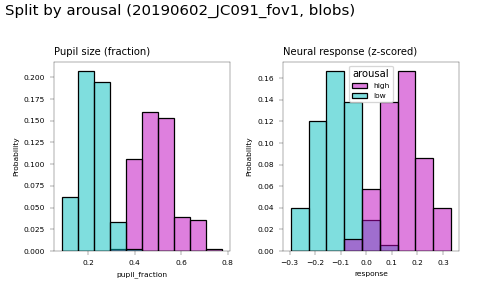

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/arousal examples splitdata__Li_20190602_JC091_fov1


In [66]:
%matplotlib notebook
fig, axn = pl.subplots(1,2,figsize=(6,3.5))
ax=axn[0]; ax.set_title('Pupil size (fraction)', loc='left', fontsize=8);
sns.histplot(splitpupil, x='pupil_fraction', hue='arousal', ax=ax,
            stat='probability', palette=arousal_colors)
ax.legend_.remove()
meanr = splitneural.groupby(['arousal', 'cell']).mean().reset_index()
ax=axn[1]; ax.set_title('Neural response (z-scored)', loc='left', fontsize=8);
sns.histplot(meanr, x='response', hue='arousal', ax=ax,
            stat='probability', palette=arousal_colors) #, cumulative=True)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.3)
fig.text(0.01, 0.95, 'Split by arousal (%s, %s)' % (dk, experiment), fontsize=12)

figname = 'splitdata__%s_%s' % (va, dk)
#pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))
print(dst_dir, 'examples', figname)

# Aggregate pupil metrics

In [68]:
PUPILDICT={}
no_pupil=[]
for (dk, exp), g in NDATA.groupby(['datakey', 'experiment']):
    try:
        fovdf, fovparams = dlcutils.load_fov_metrics(dk, exp, trial_epoch=trial_epoch)
        assert fovdf is not None
        PUPILDICT[dk] = fovdf
    except FileNotFoundError as e:
        print("%s: no pupil (%s)" % (dk, exp))
        no_pupil.append((dk, exp))
        continue
    except Exception as e:
        raise(e)

20190315_JC070_fov1: no pupil (blobs)
20190501_JC076_fov1: no pupil (blobs)
20190506_JC080_fov1: no pupil (blobs)


In [69]:
NDATA[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    14
Lm    12
V1     9
Name: visual_area, dtype: int64

#### Select stimuli and calculate correlations
select_stimuli:  
    None (all stimuli), 
    'images' (apertured or blobs),
    'fullfield' (FF grating or morphlevel=-1)


In [70]:
select_stimuli = 'images'
# --------------------------------------------------------------------
if experiment in ['gratings', 'blobs']:
    return_all = True
    rename_labels = experiment=='blobs'
    SD, incorrect_stim = aggr.check_sdfs(meta['datakey'].unique(), 
                             experiment=experiment,
                             rename=rename_labels, return_incorrect=True, 
                             return_all=return_all)

    renaming: 20190314_JC070_fov1
    renaming: 20190315_JC070_fov1
    renaming: 20190316_JC070_fov1
    renaming: 20190319_JC067_fov1
    renaming: 20190320_JC067_fov1
    renaming: 20190321_JC070_fov1
    renaming: 20190322_JC073_fov1
    renaming: 20190327_JC073_fov1
    renaming: 20190306_JC061_fov3


In [72]:
# NDATA already contains only unique dkeys
n_cuts=4
min_ncells=10
selective_only=False
rfdf_fov=None
#v-----------------------------------------------------------------------------
wrong_configs=[]
c_list=[]
CORRS=None
for (va, dk, exp), nmetrics in NDATA.groupby(['visual_area', 'datakey', 'experiment']):
    # Select cells
    rois_ = nmetrics['cell'].unique()
    if len(rois_)<min_ncells:
        print("Too few cells - (%s, %s, n=%i)" % (va, dk, len(rois_)))
        continue
    if dk not in PUPILDICT.keys():
        print("No pupil: (%s,%s)" % (va, dk))
        continue 
    # Get pupildata
    pmetrics = PUPILDICT[dk].copy()
    # Select stimuli and trials
    if experiment in ['gratings', 'blobs']:
        sdf=SD[SD.datakey==dk].copy()
        curr_cfgs = aggr.get_included_stimconfigs(sdf, experiment=exp,
                                                 select_stimuli=select_stimuli)
        if len(curr_cfgs)==0:
            wrong_configs.append((va, dk))
            continue
    else:
        curr_cfgs = sorted(NDATA['config'].unique())
    # Split trials by arousal, only keep neuraldata that has matched trials
    n_, p_ = arous.split_by_arousal(nmetrics, pmetrics, 
                                    feature_name=pupil_feature,
                                    n_cuts=n_cuts, match_cond_name='config')
    splitneural = n_.reset_index(drop=True)
    splitpupil = p_.reset_index(drop=True)
    # Get correlations
    cc_ =  get_ccdist_by_arousal(splitneural, splitpupil, rfdf_fov=rfdf_fov, 
                                 curr_cfgs=curr_cfgs)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    cc_['experiment'] = experiment
    cc_['n_cells'] = len(rois_)
    c_list.append(cc_)
CORRS = pd.concat(c_list, ignore_index=True)
print('%i datasets w wrong configs:' % len(wrong_configs))
for w in wrong_configs:
    print("    %s" % str(w))

No pupil: (Li,20190315_JC070_fov1)
Too few cells - (Li, 20190316_JC070_fov1, n=7)
Too few cells - (Li, 20190319_JC067_fov1, n=2)
Too few cells - (Li, 20190320_JC067_fov1, n=1)
Too few cells - (Li, 20190321_JC070_fov1, n=1)
Too few cells - (Li, 20190617_JC099_fov1, n=7)
No pupil: (Lm,20190506_JC080_fov1)
Too few cells - (Lm, 20191105_JC117_fov1, n=4)
Too few cells - (Lm, 20191111_JC120_fov1, n=1)
No pupil: (V1,20190501_JC076_fov1)
0 datasets w wrong configs:


In [76]:
dlc_missing_trials

,datakey,n_missing_trials,experiment
0,20190314_JC070_fov1,153,blobs
1,20190316_JC070_fov1,0,blobs
2,20190319_JC067_fov1,1018,blobs
3,20190320_JC067_fov1,649,blobs
4,20190321_JC070_fov1,226,blobs
5,20190322_JC073_fov1,56,blobs
6,20190327_JC073_fov1,0,blobs
7,20190422_JC076_fov1,2,blobs
8,20190602_JC091_fov1,737,blobs
9,20190606_JC091_fov1,754,blobs


In [240]:
badly_parsed = dlc_missing_trials[dlc_missing_trials['n_missing_trials']>500]\
                    [['datakey', 'experiment']].values
for dk in badly_parsed:
    print("Missing too many trials: %s" % str(dk))
    

Missing too many trials: ['20190319_JC067_fov1' 'blobs']
Missing too many trials: ['20190320_JC067_fov1' 'blobs']
Missing too many trials: ['20190602_JC091_fov1' 'blobs']
Missing too many trials: ['20190606_JC091_fov1' 'blobs']
Missing too many trials: ['20190510_JC083_fov1' 'blobs']
Missing too many trials: ['20190617_JC097_fov1' 'blobs']


In [241]:
bad_dkeys = [k[0] for k in badly_parsed]
CORRS[~CORRS.datakey.isin(bad_dkeys)][['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,7
Lm,9
V1,7


In [242]:
CCDIST = CORRS[~CORRS.datakey.isin(bad_dkeys)].copy()

(7310, 11)


<IPython.core.display.Javascript object>


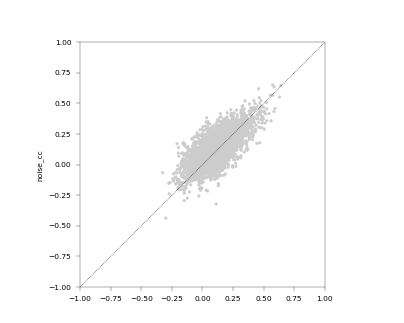

In [239]:
va = 'V1'
dk = '20191006_JC110_fov1'
metric='noise_cc'
cc_ = CCDIST[(CCDIST.visual_area==va) & (CCDIST.datakey==dk)]
print(cc_.shape)
fig, ax = pl.subplots()

sns.scatterplot(x=cc_[cc_.arousal=='high'][metric].values,
                y=cc_[cc_.arousal=='low'][metric], ax=ax, color=[0.8]*3,
                size=0.05, marker='.', edgecolor=None)
ax.legend_.remove()
ax.set_aspect('equal')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.plot([-1, 1], [-1, 1], ls=':', color='k', lw=0.5)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2)

#### General corrs

<IPython.core.display.Javascript object>


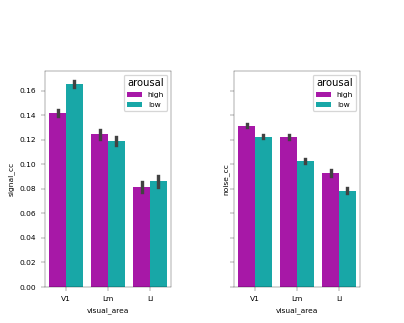

In [243]:
fig, axn = pl.subplots(1,2, sharex=True, sharey=True)
ax=axn[0]
sns.barplot(x='visual_area', y='signal_cc', data=CCDIST, ax=ax,
           hue='arousal', palette=arousal_colors, order=visual_areas)
ax=axn[1]
sns.barplot(x='visual_area', y='noise_cc', data=CCDIST, ax=ax,
           hue='arousal', palette=arousal_colors, order=visual_areas)

pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.8, wspace=0.5)

In [244]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

In [245]:
ccdist_byfov = CCDIST.groupby(['visual_area', 'datakey', 'arousal']).median()\
                     .reset_index()

<IPython.core.display.Javascript object>


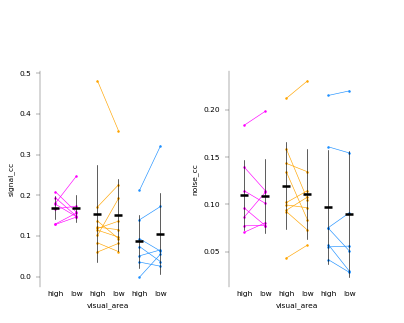

|    |   t_stat |   p_val | visual_area   | metric    |
|---:|---------:|--------:|:--------------|:----------|
|  0 |       13 |   0.938 | V1            | signal_cc |
|  1 |       22 |   1     | Lm            | signal_cc |
|  2 |        9 |   0.469 | Li            | signal_cc |
|  0 |       14 |   1     | V1            | noise_cc  |
|  1 |       18 |   0.652 | Lm            | noise_cc  |
|  2 |        8 |   0.375 | Li            | noise_cc  |


In [246]:
%matplotlib notebook 
fig, axn = pl.subplots(1,2, sharex=True, sharey=False)
s_=[]
for ax, metric in zip(axn, ['signal_cc', 'noise_cc']):
    ax, st = pplot.pairwise_compare_single_metric(ccdist_byfov, 
                        curr_metric=metric, ax=ax,
                        c1='high', c2='low', compare_var='arousal',
                        size=1, lw=0.5, return_stats=True, ttest=False,
                        edgecolor='k', facecolor=[0.8]*3, bar_ci='sd', bar_lw=0.5,
                        area_colors=area_colors, mean_plot='point',
                        point_scale=1)
    st['metric'] = metric
    s_.append(st)
stdf = pd.concat(s_)
print(stdf.to_markdown())

pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5, top=0.8, left=0.1)

# Bin.

In [247]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
n_iterations=500
n_samples=None
# ------------------------------
# Bin data
n_bins=100
to_quartile='cortical_distance'
use_quartile=True
# Bin 
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCDIST, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()

In [248]:
metric='noise_cc'
# Bin 
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCDIST, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]
# Count N pairs in each bin
pairs_per_bin = bcorrs.groupby(['visual_area', 'binned_%s' % to_quartile])\
                ['neuron_pair'].count().reset_index()\
                .rename(columns={'neuron_pair': 'n_pairs'})
pairs_per_bin['bin_value'] = [bin_lut[b] for b \
                               in pairs_per_bin['binned_%s' % to_quartile]]

#### initial plotting

<IPython.core.display.Javascript object>


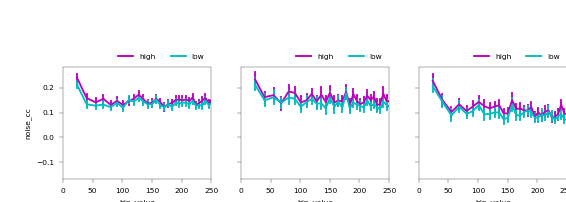

In [249]:
n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 3
x_var = 'binned_%s' % to_quartile
fit_sites = False
use_binned = False

cnt_grouper = [x_var, 'arousal'] 
if fit_sites:
    cnt_grouper.append('datakey')
    
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fov_cc0 = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fov_cc0 = cc_.copy()
    sns.lineplot(x='bin_value', y=metric, data=fov_cc0, hue='arousal',
                palette=arousal_colors, err_style='bars', estimator=np.mean,
                 ax=ax, markers='.')
    ax.set_xlim([0, 250])
#     for cond, fov_cc in fov_cc0.groupby('arousal'):
# #         ax.scatter(x=to_quartile, y='signal_cc', data=fov_cc, 
# #                     s=2, color=arousal_colors[cond])
#         res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=use_binned,
#                                                 normalize_x=True, func='halflife',
#                                                 estimator='median',
#                                                 metric=metric,
#                                                 to_quartile=to_quartile,
#                                                 return_inputs=True)
#         if all(res_.isnull()):
#             print("BINNED, no fit: %s" % va)
#             label='no fit'
#         else:
#             fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
#             label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
#                             % (va, res_.tau, res_.init, res_.constant, res_.R2)
#             ax.plot(xvals, fit_y, color=arousal_colors[cond], label=label)
#     ax.set_xlabel('cortical distance (um)')
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
       #ax.set_title(va)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.7)
# leg_h = pplot.custom_legend_markers(colors=[arousal_colors[c] for c in ['high', 'low']],
#                                     labels=['high', 'low'])
# axn[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
#                frameon=False, title='arousal')


In [98]:
CORRS[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    5
Lm    4
V1    3
Name: visual_area, dtype: int64

<IPython.core.display.Javascript object>


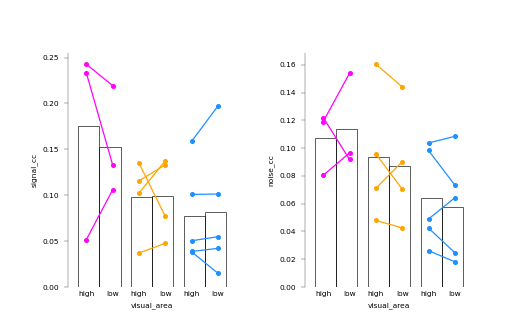

|    |   t_stat |   p_val | visual_area   | metric    |
|---:|---------:|--------:|:--------------|:----------|
|  0 |        2 |   0.75  | V1            | signal_cc |
|  1 |        4 |   0.875 | Lm            | signal_cc |
|  2 |        4 |   0.438 | Li            | signal_cc |
|  0 |        2 |   0.75  | V1            | noise_cc  |
|  1 |        3 |   0.625 | Lm            | noise_cc  |
|  2 |        4 |   0.438 | Li            | noise_cc  |


In [99]:
meancc = CORRS.groupby(['visual_area', 'datakey', 'arousal']).mean().reset_index()

metric='signal_cc'
# Paired: spstats.wilcoxon()
offset=2
fig, axn = pl.subplots(1,2, figsize=(6.5, 4))
fig.patch.set_facecolor('w')

s_=[]
for ai, metric in enumerate(['signal_cc', 'noise_cc']):
    ax=axn[ai]
    ax, pstats = pplot.pairwise_compare_single_metric(meancc, 
                 curr_metric=metric, ax=ax, size=3,
                 c1='high', c2='low', compare_var='arousal', 
                 ttest=False, return_stats=True, bar_ci=None)
    pstats['metric'] = metric
    offset=.2; h=.02;
    pplot.annotate_sig_on_paired_plot(ax, meancc, pstats, metric, offset=offset, h=h)
    s_.append(pstats)
statsdf = pd.concat(s_)
print(statsdf.to_markdown())

pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5, top=0.85)

In [144]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

# Bootstrap params

In [145]:
use_binned=False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
# Fit function
resdf = cr.bootstrap_fitdecay(bcorrs, use_binned=use_binned, fit_sites=fit_sites,
                         metric=metric, to_quartile=to_quartile,
                         bin_column='bin_value', normalize_x=True,
                         n_iterations=n_iterations)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
(500, 6)


In [146]:

print("init: %i/%i iters too big" % (resdf[resdf.init>1].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<=-1].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>2000].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.init<=0].shape[0], n_iterations))


init: 0/500 iters too big
init: 0/500 iters too small
tau: 0/500 iters too big
tau: 0/500 iters too small


In [147]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=1) & (resdf['init']>=-1) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)
                   & (resdf['R2']>0.5)].copy()
else:
    finalres = resdf[(resdf['init']<=1) & (resdf['init']>=-1) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)].copy()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(1500, 6) (1500, 6)


In [153]:
select_stimuli

'all'

In [154]:
stim_str = '' 
if experiment in ['gratings', 'blobs']:
    if select_stimuli!='images':
        stim_str = '_FF' if select_stimuli=='fullfield' else '_%s' % select_stimuli

results_fpath = os.path.join(dst_dir, 'fitresults_%s%s.pkl' % (bin_type, stim_str))
with open(results_fpath, 'wb') as f:
    pkl.dump(resdf, f, protocol=2)
print('saved: %s' % results_fpath)

saved: /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/fitresults_cut-fitraw-avgfov.pkl


<IPython.core.display.Javascript object>


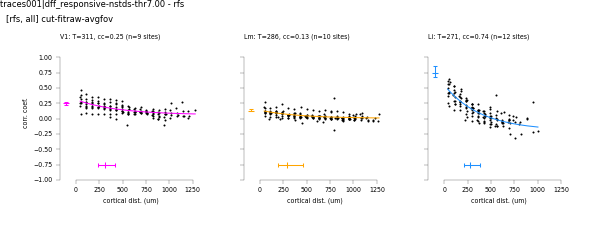

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds distance_curves_cut-fitraw-avgfov


In [155]:
use_best_r2=False
fig = cr.plot_fit_distance_curves(bcorrs, finalres,  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, x_pos=-100, y_pos=-0.75,
                            ylim=(-1, 1.2))
fig.text(0.01, 0.9, '[%s, %s] %s' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = 'distance_curves_%s%s' % (bin_type, stim_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [130]:
resdf.max()

init           147584.489969
tau              1123.077927
constant            0.194846
R2                    0.4485
iteration              499.0
visual_area               V1
dtype: object

<IPython.core.display.Javascript object>


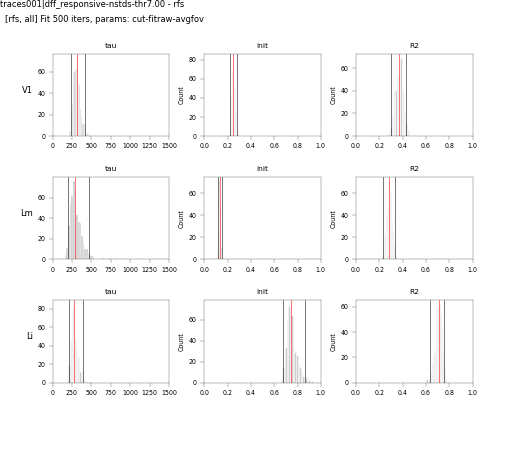

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds param_distns_cut-fitraw-avgfov


In [156]:
fig, axn = pl.subplots(3,3, figsize=(7,6))

for va, rd_ in finalres.dropna().groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, 1500])
        elif param=='init':
            ax.set_xlim([0, 1])
        elif param=='R2':
            ax.set_xlim([0, 1])
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, wspace=0.3)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.95, "[%s, %s] Fit %i iters, params: %s" 
         % (experiment, select_stimuli, n_iterations, bin_type), fontsize=8)

figname = 'param_distns_%s%s' % (bin_type, stim_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


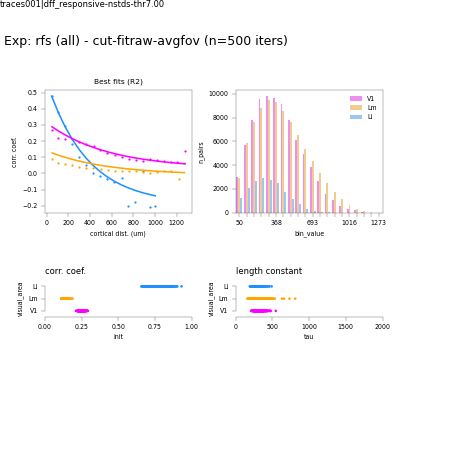

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds fitdecay_cut-fitraw-avgfov


In [157]:
x_var='binned_%s' % to_quartile
metric='signal_cc'
cnt_grouper = [x_var, 'datakey'] if fit_sites else [x_var]
# ---------------------------
# plot
fig, axn = pl.subplots(2,2, figsize=(6,6))
ax=axn[0,0]
for va, cc_ in bcorrs.groupby('visual_area'):
    cols=['init', 'tau', 'constant', 'R2', 'iteration', 'visual_area']
    init, tau, const, r2, _, _ = finalres.loc[finalres[finalres.visual_area==va]\
                                      ['R2'].idxmax(),cols]
    data = cc_.groupby('binned_%s' % to_quartile).median()
    xdata = data.sort_values(by=to_quartile)[to_quartile].values
    ydata = data.sort_values(by=to_quartile)[metric].values
    fit_y = cr.func_halflife(xdata, init, tau, const)
    fit_x = xdata.copy()
    ax.scatter(xdata, ydata, color=area_colors[va], marker='.', s=5)
    ax.plot(fit_x, fit_y, area_colors[va]) # label='fitted line')
    ax.set_ylabel('corr. coef.')
    ax.set_xlabel('cortical dist. (um)')
    ax.set_title("Best fits (R2)")
    
ax=axn[0, 1]
sns.barplot(x='bin_value', y='n_pairs', data=pairs_per_bin,
              hue='visual_area', ax=ax, palette=area_colors,
              hue_order=visual_areas, alpha=0.5)
ax.set_xticks(np.arange(0, len(bin_values))) #[int(round(i)) for i in bin_values]
xtick_bins = [int(round(i)) for i in bin_values][0::5]
xtick_bins.append(int(round(bin_values[-1])))
ax.set_xticklabels([int(round(i)) if int(round(i)) in xtick_bins else '' for i in bin_values])
ax.legend(bbox_to_anchor=(1,1.), loc='upper right', frameon=False)

for ai, param in enumerate(['init', 'tau']):
    ax=axn[1, ai]
    sns.stripplot(x=param, y='visual_area', hue='visual_area', data=finalres, ax=ax, 
            jitter=False, palette=area_colors, marker='.')
    ax.legend_.remove()
    title = 'corr. coef.' if param=='init' else 'length constant'
    ax.set_title(title, loc='left', fontsize=8)    
    tmin = 0
    tmax=2000 if param=='tau' else 1.0
    ax.set_xlim([tmin, tmax])
    ax.set_xticks(np.linspace(tmin, tmax, 5))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0)*0.25)
    sns.despine(trim=True, ax=ax)

fig.text(0.01, 0.9, 'Exp: %s (%s) - %s (n=%i iters)' \
         % (experiment, select_stimuli, bin_type, n_iterations), fontsize=12)
pl.subplots_adjust(bottom=0.2, right=0.85, left=0.1, wspace=0.3, top=0.8,
    hspace=0.2)
sns.despine(trim=True, ax=ax)

figname = 'fitdecay_%s%s' % (bin_type, stim_str)
pplot.label_figure(fig, data_id)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [269]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

# Test fit params

<IPython.core.display.Javascript object>


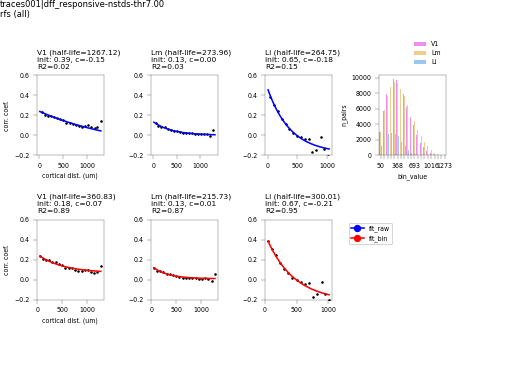

In [152]:
%matplotlib notebook
fig, axn = pl.subplots(2,4, figsize=(7,5))
for va, cc_ in bcorrs.groupby('visual_area'):
    ax=axn[0, visual_areas.index(va)]
    #xdata = cc_.sort_values(by=to_quartile)['cortical_distance'].values
    #ydata = cc_.sort_values(by=to_quartile)['signal_cc'].values
    res_=None
    data = cc_.groupby('binned_%s' % to_quartile).mean()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)['signal_cc'].values
    ax.scatter(xd, yd, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(cc_, use_binned=False,
                                                normalize_x=True,
                                                metric=metric, bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("RAW, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='b')
        label = '%s (half-life=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_ylim([-0.2, 0.6])
    ax.set_title(label, loc='left')

for va, cc_ in bcorrs.groupby('visual_area'):
    ax=axn[1, visual_areas.index(va)]
    data = cc_.groupby('binned_%s' % to_quartile).mean()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)['signal_cc'].values
    ax.scatter(xd, yd, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(cc_, use_binned=True,
                                                normalize_x=True,
                                                metric=metric, bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (half-life=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_ylim([-0.2, 0.6])
    ax.set_title(label, loc='left')
    
ax=axn[0, 3]
sns.barplot(x='bin_value', y='n_pairs', data=pairs_per_bin,
              hue='visual_area', ax=ax, palette=area_colors,
              hue_order=visual_areas, alpha=0.5)
ax.set_xticks(np.arange(0, len(bin_values))) #[int(round(i)) for i in bin_values]
xtick_bins = [int(round(i)) for i in bin_values][0::5]
xtick_bins.append(int(round(bin_values[-1])))
ax.set_xticklabels([int(round(i)) if int(round(i)) in xtick_bins else '' for i in bin_values])
ax.legend(bbox_to_anchor=(1,1.05), loc='lower right', frameon=False)

pl.subplots_adjust(hspace=0.6, wspace=0.5, right=0.95, left=0.1, top=0.8)

pplot.label_figure(fig, '%s\n%s (%s)' % (data_id, experiment, select_stimuli))

leg_h = pplot.custom_legend_markers(colors=['b', 'r'], labels=['fit_raw', 'fit_bin'])
axn[1, 2].legend(handles=leg_h, bbox_to_anchor=(1.2,1), loc='upper left')
axn[1,3].axis('off')

for ci in [0, 1]:
    axn[ci,0].set_xlabel('cortical dist. (um)')
    axn[ci,0].set_ylabel('corr. coef.')

pl.subplots_adjust(left=0.07, right=0.85, bottom=0.2, hspace=0.8, wspace=0.7, top=0.8)

In [128]:
g_list=[]
for (va, dk, bc), g in \
    bcorrs.groupby(['visual_area', 'datakey', 'binned_%s' % to_quartile]):
    if len(g['neuron_pair'])>=20:
        g_list.append(g)
bcorrs2 = pd.concat(g_list, axis=0,  ignore_index=True)

In [129]:
int(np.random.rand(1)[0]*500)


384

# Average FOV, then fit on each

<IPython.core.display.Javascript object>


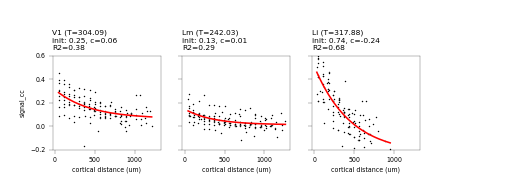

In [219]:
n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 3
x_var = 'binned_%s' % to_quartile
metric = 'signal_cc'

cnt_grouper = [x_var, 'datakey'] if fit_sites else [x_var]
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    
    data = fov_cc.groupby(x_var).median()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)['signal_cc'].values
    #ax.plot(xd, yd, lw=0, color='k', marker='.')
    sns.scatterplot(x=to_quartile, y='signal_cc', data=fov_cc, ax=ax,
                    s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                                normalize_x=True, func='halflife',
                                                estimator='median',
                                                metric=metric, bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (T=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_ylim([-0.2, 0.6])
    ax.set_title(label, loc='left')
    ax.set_xlabel('cortical distance (um)')
   #ax.set_title(va)
    
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.7)

In [478]:
importlib.reload(cr)
from scipy.optimize import curve_fit
cc_ = bcorrs2[(bcorrs2.visual_area=='Li')]

In [25]:
mean_fov = bcorrs.groupby(['visual_area', 'datakey', 'binned_%s' % to_quartile])\
                 .mean().reset_index().dropna().reset_index(drop=True)
mean_fov['n_cells'].min()

11.0

In [26]:
mean_fov[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    12
Lm    10
V1     9
Name: visual_area, dtype: int64

In [27]:
# mean_fov = bcorrs2.groupby(['visual_area', 'datakey', 'binned_%s' % to_quartile])\
#                  .mean().reset_index().dropna().reset_index(drop=True)
# mean_fov['n_cells'].min()

In [28]:
min_dist = mean_fov['cortical_distance'].min()
max_dist = mean_fov['cortical_distance'].max()
print(min_dist, max_dist)
cmap='viridis'

39.70554804370723 1278.805621676808


<IPython.core.display.Javascript object>


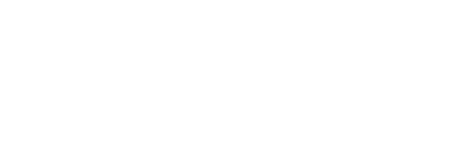

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds tuningVdist_perFOV_cut-20bins


In [29]:
x_var = 'bin_value' # 'cortical_distance' # 'binned_%s' % to_quartile
metric = 'signal_cc'
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc_ in mean_fov.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
#     sns.barplot(x=x_var, y=metric, data=cc_, ax=ax,
#                color=[0.7]*3, ci=None)
    sns.scatterplot(x=x_var, y=metric, data=cc_, ax=ax,
               palette=cmap, hue='cortical_distance',
               size=3, hue_norm=(min_dist, max_dist))
    ax.get_legend().remove()
    ax.set_xlim([0, 1200])
    ax.set_xlabel('cortical distance (um)')
    ax.set_title(va)
    ax.set_ylim([-0.3, 0.6])
# Cbar
norm = pl.Normalize(min_dist, max_dist)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cax = fig.add_axes([0.92,0.3,0.01,0.4]) 
fig.colorbar(sm, cax=cax)

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8, wspace=0.2)
fig.text(0.01, 0.9, '[%s, %s] Avg. tuning vs. distance (each dot is 1 site)' \
        % (experiment, select_stimuli))

pplot.label_figure(fig, data_id)
figname = 'tuningVdist_perFOV_%s-%ibins' % (cut_str, n_bins)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


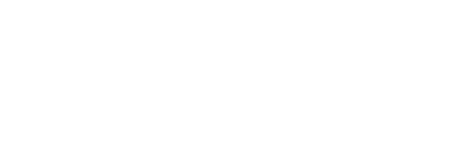

In [31]:
x_var = 'binned_%s' % to_quartile
metric = 'signal_cc'
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc_ in mean_fov.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cc_mean = cc_.groupby('binned_%s' % to_quartile).mean().reset_index()
#     data = cc_mean.groupby('binned_%s' % to_quartile).mean()
#     xd = data.sort_values(by=to_quartile)['cortical_distance'].values
#     yd = data.sort_values(by=to_quartile)['signal_cc'].values
    sns.scatterplot(x='cortical_distance', y='signal_cc', 
                    data=cc_, s=10, color='k', ax=ax)
    res_, xvals, yvals = cr.fit_decay_on_binned(cc_, use_binned=False,
                                                normalize_x=True,
                                                metric=metric, bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (half-life=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_ylim([-0.2, 0.6])
    ax.set_title(label, loc='left')
    #ax.get_legend().remove()
    #ax.set_xlim([0, 1200])
    ax.set_xlabel('cortical distance (um)')
   #ax.set_title(va)
    ax.set_ylim([-0.3, 0.6])
    
pl.subplots_adjust(top=0.8)

In [32]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


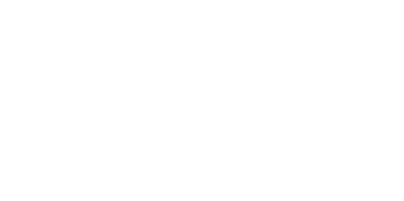

<IPython.core.display.Javascript object>


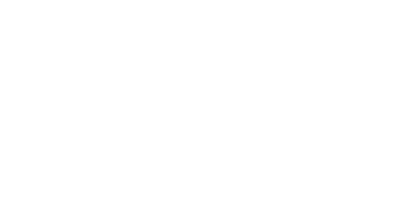

<IPython.core.display.Javascript object>


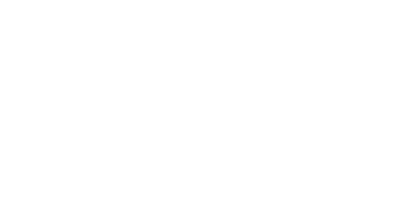

<IPython.core.display.Javascript object>


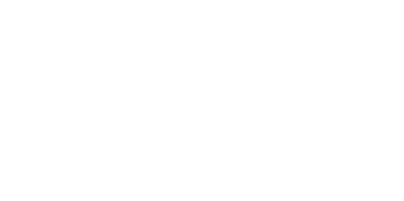

In [33]:
### Test fitting functions here
use_binned=False
for use_binned in [True, False]:
    for normalize_x in [True, False]:
        fig, axn = pl.subplots(1,3, figsize=(6,3), sharex=True, sharey=True)
        fig.text(0.01, 0.95, 'Binned: %s, Normalize X: %s' % (str(use_binned), str(normalize_x)))
        
        for va, cc_ in bcorrs.groupby('visual_area'):
            ax=axn[visual_areas.index(va)]
            # ----------------------------------
            res_, xvals, yvals = cr.fit_decay_on_binned(cc_, use_binned=use_binned,
                                                    normalize_x=normalize_x,
                                                    metric=metric, bin_column=bin_column,
                                                    to_quartile=to_quartile,
                                                    return_inputs=True)
            fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
            
            data = cc_.groupby('binned_%s' % to_quartile).mean().reset_index()
            plot_x = data.sort_values(by=to_quartile)[bin_column].values
            plot_y = data.sort_values(by=to_quartile)[metric].values
            # plot
            ax.plot(plot_x, plot_y, 'k.', markersize=1)
            ax.plot(xvals, fit_y, 'r')
            label = '%s (half-life=%.2f)\ninit: %.2f\ntau=%.2f\nc=%.2f' \
                                % (va, res_.tau, res_.init, res_.tau, res_.constant)
            ax.set_title(label, loc='left')
        pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.7, wspace=0.5)

In [240]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds'

# Example FOV & CELL

In [276]:
va = 'V1'
dk='20190617_JC097_fov1'
selective_only=False

ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# Select cells
if selective_only:
    curr_cells = gdata_u[(gdata_u.visual_area==va) 
                    & (gdata_u.datakey==dk)]['cell'].unique()
    if len(curr_cells)<5:
        print("Skipping.")
else:
    curr_cells = ndf['cell'].unique()
# Select stimuli and trials
sdf = aggr.get_stimuli(dk, experiment=experiment)
curr_cfgs = sdf.index.tolist()
# corrs, zscored = cr.calculate_corrs(ndf, return_zscored=True,
#                                  curr_cells=curr_cells, curr_cfgs=curr_cfgs)
ccdist, zscored = cr.get_ccdist(ndf, return_zscored=True,
                                 curr_cells=curr_cells, curr_cfgs=curr_cfgs)

In [ ]:
importlib.reload(cr)

#### Representational Similarity Matrix

In [60]:
params = cr.get_key_stimulus_params(experiment)
tuning_ = cr.trial_averaged_responses(zscored, sdf, params=params)
rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]

<IPython.core.display.Javascript object>


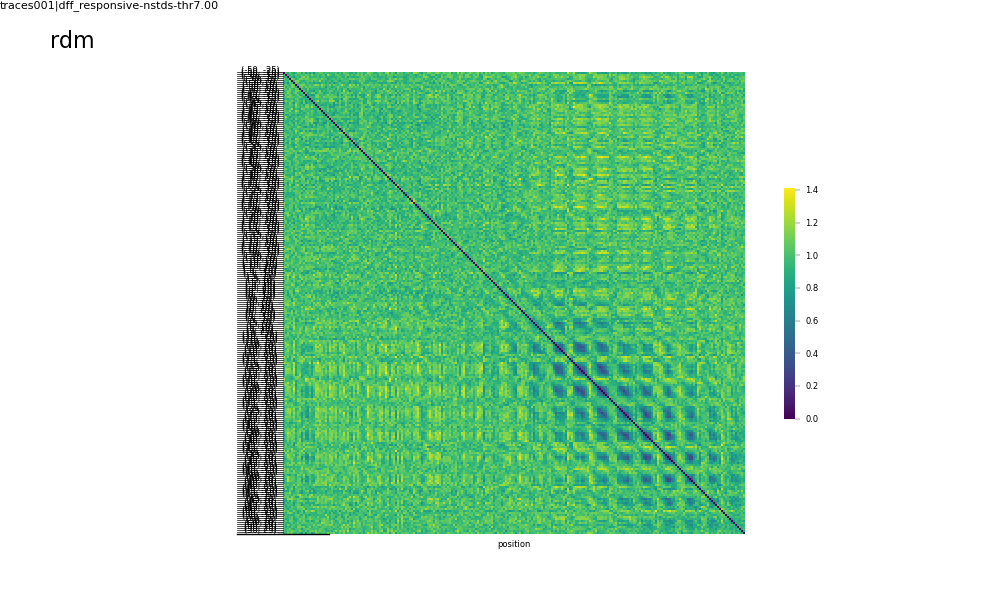

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds rdm__EXAMPLE_20190617_JC097_fov1


In [66]:
%matplotlib notebook
plot_rdm = True
plot_name = 'rdm' if plot_rdm else 'corr'

mat_, msk_, xlabels =  cr.get_correlation_matrix(tuning_, sdf,
                            experiment=experiment)

fig, ax = pl.subplots(1,1,figsize=(10, 6))
ax = cr.plot_correlation_matrix(mat_, plot_rdm=plot_rdm, ax=ax,
                            vmin=None, vmax=None)
fig.text(0.05, 0.92, plot_name, fontsize=16)

pplot.label_figure(fig, data_id)

figname = '%s__EXAMPLE_%s' % (plot_name, dk)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [65]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds'

#### Correlations

<IPython.core.display.Javascript object>


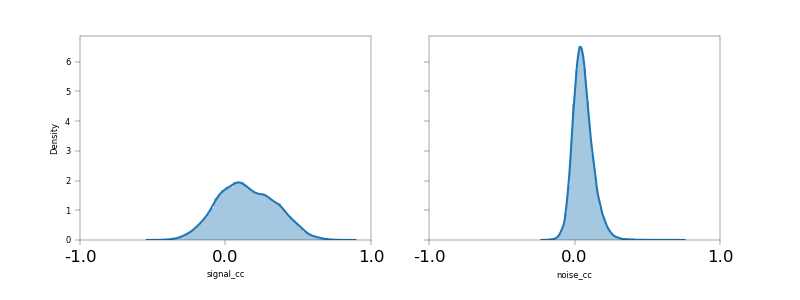

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [67]:
fig, axn = pl.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
sns.distplot(corrs['signal_cc'], ax=axn[0])
sns.distplot(corrs['noise_cc'], ax=axn[1])
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.set_xticks(np.linspace(-1, 1, 3))
    ax.set_xticklabels(np.linspace(-1, 1, 3), fontsize=12)
pl.subplots_adjust(bottom=0.2, left=0.1)

### Signal corrs. vs. Cortical distance

#### Load spatial info

In [328]:
importlib.reload(cr)
%matplotlib notebook

In [72]:
# Binning params
n_bins=4
use_quartile=True
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)


| binned_cortical_distance   |   cortical_distance |   signal_cc |
|:---------------------------|--------------------:|------------:|
| 1st                        |             160.484 |   0.188009  |
| 2nd                        |             328.105 |   0.168662  |
| 3rd                        |             477.695 |   0.134745  |
| 4th                        |             719.332 |   0.0970089 |


<IPython.core.display.Javascript object>


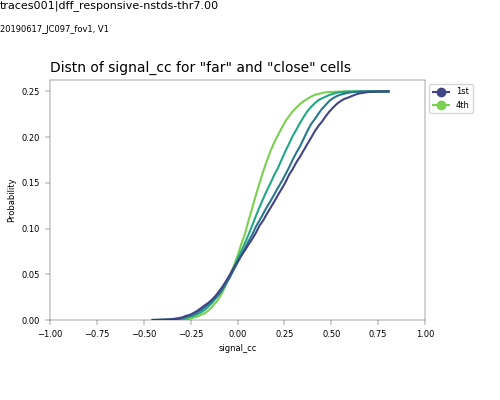

First and Last ~cortical_distance~ quartiles, diff <signal_cc> = nan


Text(0.0, 1.0, 'Distn of signal_cc for "far" and "close" cells')

In [78]:
metric = 'signal_cc'
bcorrs, bins_ = cr.bin_column_values(ccdist, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
      .mean().to_markdown())

fig, ax = pl.subplots(figsize=(5,4))
ax = cr.plot_quartile_dists_FOV(bcorrs, metric=metric, to_quartile=to_quartile,
                    bin_labels=bin_labels, bin_colors=bin_colors, ax=ax,
                    cumulative=True, element='poly', fill=False, 
                    plot_median=False, extrema_only=False, lw=5)
ax.set_title('%s' % (metric), loc='left', fontsize=12)
ax.set_xlim([-1, 1])
# legend
leg_h = pplot.custom_legend_markers(colors=[bin_colors[i] for i in plot_bins],
                                   labels=plot_bins)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left')

# print some stuff
lo_median = ccdist[ccdist['binned_%s' % to_quartile]==0][metric].median()
hi_median = ccdist[ccdist['binned_%s' % to_quartile]==3][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.85)

pplot.label_figure(fig, data_id)
fig.text(0.0, 0.92, '%s, %s' % (dk, va))
fig.axes[0].set_title('Distn of %s for "far" and "close" cells' % metric, \
                    loc='left', fontsize=10)

#### Receptive fields?

In [82]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
rfs_ = combined_rfs[(combined_rfs.visual_area==va) & (combined_rfs.datakey==dk)
                   & (combined_rfs['cell'].isin(rois_))].copy()
rfs_.index = rfs_['cell'].values
# Get rf overlaps
rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
overlaps_ = rfutils.get_rf_overlaps(rf_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 \
                            in overlaps_[['cell_1', 'cell_2']].values]
# merge RF and CC/distance data
has_both = np.intersect1d(overlaps_['neuron_pair'], ccdist['neuron_pair'])
ccrf = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
               ccdist[ccdist['neuron_pair'].isin(has_both)])

In [85]:
# Bin into quartiles
to_quartile='signal_cc'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(ccrf, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)

| binned_signal_cc   |   signal_cc |   area_overlap |
|:-------------------|------------:|---------------:|
| 1st                |    0.142452 |       0.267805 |
| 2nd                |    0.307437 |       0.396659 |
| 3rd                |    0.411999 |       0.51646  |
| 4th                |    0.540153 |       0.6297   |
First and Last ~signal_cc~ quartiles, diff <area_overlap> = 0.37


<IPython.core.display.Javascript object>


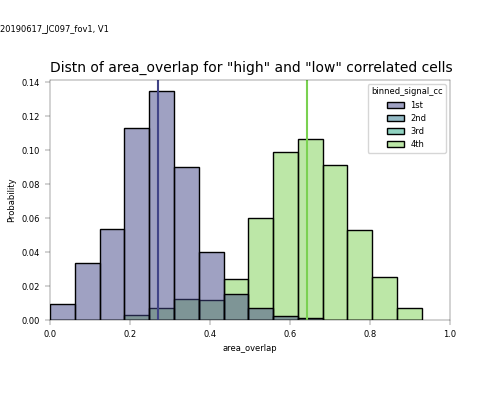

Text(0.0, 1.0, 'Distn of area_overlap for "high" and "low" correlated cells')

In [86]:
%matplotlib notebook
metric = 'area_overlap'
# print info
print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
      .mean().to_markdown())
lo_median = bcorrs[bcorrs['binned_%s' % to_quartile]==bin_labels[0]][metric].median()
hi_median = bcorrs[bcorrs['binned_%s' % to_quartile]==bin_labels[-1]][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))

# Plot metric X for top and bottom quartiles
fig, ax = pl.subplots(figsize=(5,4))
plot_bins = [bin_labels[0], bin_labels[-1]]
ax = cr.plot_quartile_dists_FOV(bcorrs, metric=metric, to_quartile=to_quartile,
                              bin_labels=bin_labels, bin_colors=bin_colors, ax=ax)
ax.set_xlim([0, 1])
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
fig.text(0.0, 0.92, '%s, %s' % (dk, va))
fig.axes[0].set_title('Distn of %s for "high" and "low" correlated cells'\
                    % metric, loc='left', fontsize=10)

# pplot.label_figure(fig, data_id)
# figname = '%s_Q_%s__EXAMPLE_%s' % (metric, to_quartile, dk)
# print(figname)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


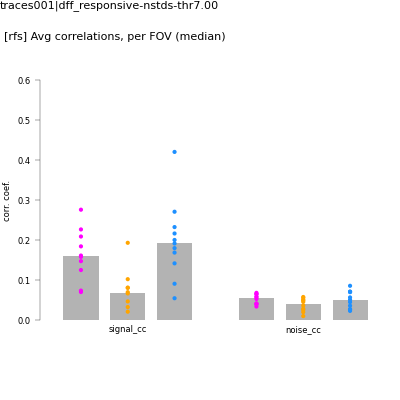

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds correlations_byfov_allcells


In [96]:
%matplotlib notebook
meancorrs = CORRS.groupby(['visual_area', 'datakey'])[['signal_cc', 'noise_cc']]\
                .mean() #.reset_index()
df_s = meancorrs.stack()\
    .rename_axis(index={'id': 'id', 'date': 'date', None: 'corr_type'})\
    .rename('corr_value').reset_index()

g = sns.FacetGrid(df_s, height=4)
g.map_dataframe(sns.stripplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=area_colors, 
                hue_order=visual_areas, dodge=True, size=3, jitter=False)
g.map_dataframe(sns.barplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=bw_colors, 
                estimator=np.median, #ci='sd',
                hue_order=visual_areas, dodge=True, errwidth=0)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.change_width(g.fig.axes[0], 0.2)
sns.despine(bottom=True)
pl.ylim([0, 0.6])
g.fig.axes[0].tick_params(which='both', axis='x', size=0)
pl.ylabel('corr. coef.')
pplot.label_figure(g.fig, data_id)
g.fig.text(0.01, 0.9,'[%s] Avg correlations, per FOV (median)' \
           % experiment, fontsize=8)

plot_type = 'selectiveonly' if selective_only else 'allcells'
figname = 'correlations_byfov_%s' % plot_type
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Signal corrs for near vs. far cells

In [97]:
n_bins=4
custom_bins=False
cmap='viridis'
# ------------------------------
custom_bins=False
use_quartile=True
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CORRS, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()

<IPython.core.display.Javascript object>


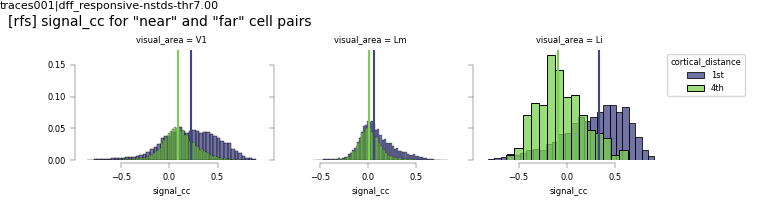

signal_cc_Q_cortical_distance_aggr


In [98]:
metric = 'signal_cc'
# Plot metric X for top and bottom quartiles
g = cr.plot_quartile_dists_by_area(bcorrs, bin_labels, bin_colors,
                        metric=metric,
                        to_quartile=to_quartile)
sns.despine(trim=True, offset=2)
g.fig.text(0.01, 0.87, '[%s] %s for "near" and "far" cell pairs' \
           % (experiment, metric), fontsize=10)
# Save
pplot.label_figure(g.fig, data_id)
figname = '%s_Q_%s_aggr' % (metric, to_quartile)
print(figname)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))